## Observational social learning task with a basic working-memory-based network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd

### Task is defined by the Environment node

In [67]:
class Environment():
    def __init__(self, sid, trial, time_sample=2, dt=0.001):
        self.time_sample = time_sample
        self.dt = dt
        self.sid = sid
        self.trial = trial
        self.empirical = pd.read_pickle(f"data/behavior.pkl").query("sid==@sid & trial==@trial")
        self.color = 0
        self.decay = 0
        self.degree = 0
        self.inhibit1 = 0
        self.inhibit2 = 0
        self.stage = 0
        self.n_neighbors = len(self.empirical['who'].unique()) - 1
        # create input arrays
        self.colors = []
        self.decays = []
        self.degrees = []
        self.inhibit1s = []
        self.inhibit2s = []
        tt = int(self.time_sample / self.dt)
        tt2 = int(tt/2)
        self.T = self.time_sample + 3*self.n_neighbors*self.time_sample - self.dt
        for stage in range(4):
            if stage==0:
                color = self.empirical.query("stage==@stage")['color'].to_numpy()[0]
                n_samples = 1
                decay = 1 / n_samples
                degree = 0
                self.colors.extend(2*color-1 * np.ones((tt, 1)))
                self.decays.extend(decay * np.ones((tt, 1)))
                self.degrees.extend(degree * np.ones((tt, 1)))
                self.inhibit1s.extend(1 * np.ones((tt2, 1)))
                self.inhibit2s.extend(0 * np.ones((tt2, 1)))
                self.inhibit1s.extend(0 * np.ones((tt2, 1)))
                self.inhibit2s.extend(1 * np.ones((tt2, 1)))
            else:
                for n in range(self.n_neighbors):
                    color = self.empirical.query("stage==@stage")['color'].to_numpy()[n]
                    degree = 0 if stage==1 else self.empirical.query("stage==@stage")['RD'].to_numpy()[n]
                    n_samples = 1 + (stage-1)*self.n_neighbors + (n+1)                      
                    decay = 1 / n_samples
                    self.colors.extend(2*color-1 * np.ones((tt, 1)))
                    self.decays.extend(decay * np.ones((tt, 1)))
                    self.degrees.extend(degree * np.ones((tt, 1)))
                    self.inhibit1s.extend(1 * np.ones((tt2, 1)))
                    self.inhibit2s.extend(0 * np.ones((tt2, 1)))
                    self.inhibit1s.extend(0 * np.ones((tt2, 1)))
                    self.inhibit2s.extend(1 * np.ones((tt2, 1)))
        self.colors = np.array(self.colors).flatten()
        self.decays = np.array(self.decays).flatten()
        self.degrees = np.array(self.degrees).flatten()
        self.inhibit1s = np.array(self.inhibit1s).flatten()
        self.inhibit2s = np.array(self.inhibit2s).flatten()
                    
    def sample(self, t):
        tidx = int(t/self.dt)
        return [self.colors[tidx], self.decays[tidx], self.degrees[tidx], self.inhibit1s[tidx], self.inhibit2s[tidx]]

    sid  trial  network  stage  who  color  degree       RD  action
10    1      2       15      0    3      1       2  0.00000       1
11    1      2       15      1    7      0       5  0.55556       1
12    1      2       15      1    4      1       2  0.22222       1
13    1      2       15      2    4      1       2  0.22222       1
14    1      2       15      2    7      0       5  0.55556       1
15    1      2       15      3    7      0       5  0.55556       0
16    1      2       15      3    4      1       2  0.22222       0


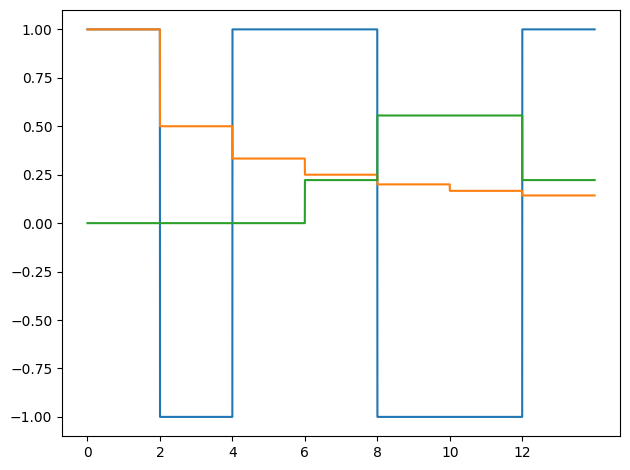

In [76]:
## Check Environment inputs
env = Environment(sid=1, trial=2, time_sample=2)
print(env.empirical)
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(0, env.T+env.dt, env.dt), env.colors)
ax.plot(np.arange(0, env.T+env.dt, env.dt), env.decays)
ax.plot(np.arange(0, env.T+env.dt, env.dt), env.degrees)
# ax.plot(np.arange(0, env.T+env.dt, env.dt), env.n_samples)
ax.set(xticks = np.arange(0, env.T+env.dt, env.time_sample))
plt.tight_layout()
plt.show()

### Define the neural network

In [64]:
def build_network(env, n_neurons=500, seed_net=0, syn_feedback=0.1, z=0):
    net = nengo.Network(seed=seed_net)
    net.z = z
    func_obs = lambda t: env.sample(t)[0]
    func_decay = lambda t: env.sample(t)[1]
    func_degree = lambda t: env.sample(t)[2]
    func_inh1 = lambda t: env.sample(t)[3]
    func_inh2 = lambda t: env.sample(t)[4]
    func_load = lambda x: (x[0] - x[1]) * x[2]
    func_diff = lambda x: (x[0] - x[1])
    func_choice = lambda x: -1 if x[0] < 0 else 1
    func_weight = lambda x: x[0] + net.z * x[1]  # decay term plus/minus degree term times subject parameter "z"

    with net:
        # external inputs
        net.input_obs = nengo.Node(func_obs)
        net.input_decay = nengo.Node(func_decay)
        net.input_degree = nengo.Node(func_degree)
        net.inhibit1 = nengo.Node(func_inh1)
        net.inhibit2 = nengo.Node(func_inh2)
        net.weight_out = nengo.Node(size_in=1)
        # ensembles
        net.obs = nengo.Ensemble(n_neurons, 1)
        net.decay = nengo.Ensemble(n_neurons, 1)
        net.degree = nengo.Ensemble(n_neurons, 1)
        net.weight = nengo.Ensemble(2*n_neurons, 2, radius=2)
        net.combined = nengo.Ensemble(4*n_neurons, 4, radius=3)
        net.memory = nengo.Ensemble(n_neurons, 1)
        net.temp = nengo.Ensemble(n_neurons, 2)
        net.old = nengo.Ensemble(n_neurons, 1)
        net.decision = nengo.Ensemble(n_neurons, 1)
        # connections
        nengo.Connection(net.input_obs, net.obs)
        nengo.Connection(net.input_decay, net.decay)
        nengo.Connection(net.input_degree, net.degree)
        nengo.Connection(net.decay, net.weight[0])
        nengo.Connection(net.degree, net.weight[1])
        nengo.Connection(net.obs, net.combined[0])
        nengo.Connection(net.old, net.combined[1])
        nengo.Connection(net.weight, net.combined[2], function=func_weight)
        nengo.Connection(net.weight, net.weight_out, function=func_weight)
        nengo.Connection(net.combined, net.memory, function=func_load, transform=syn_feedback)
        nengo.Connection(net.memory, net.memory, synapse=syn_feedback)
        nengo.Connection(net.memory, net.temp[0])
        nengo.Connection(net.old, net.temp[1])
        nengo.Connection(net.temp, net.old, function=func_diff)
        nengo.Connection(net.old, net.old, synapse=syn_feedback)
        nengo.Connection(net.inhibit1, net.temp.neurons, transform=-1e3*np.ones((net.temp.n_neurons, 1)))
        nengo.Connection(net.inhibit2, net.combined.neurons, transform=-1e3*np.ones((net.combined.n_neurons, 1)))
        nengo.Connection(net.memory, net.decision, function=func_choice)
        # probes
        net.probe_input = nengo.Probe(net.input_obs, synapse=0.01)
        net.probe_obs = nengo.Probe(net.obs, synapse=0.01)
        net.probe_weight = nengo.Probe(net.weight_out, synapse=0.01)
        net.probe_memory = nengo.Probe(net.memory, synapse=0.01)
        net.probe_old = nengo.Probe(net.old, synapse=0.01)
        net.probe_decision = nengo.Probe(net.decision, synapse=0.01)
    return net

### Simulate the network for one observation

In [65]:
def simulate(env, z=0, seed_sim=0, seed_net=0, progress_bar=True):
    net = build_network(env, seed_net=seed_net, z=z)
    sim = nengo.Simulator(net, seed=seed_sim, progress_bar=progress_bar)
    with sim:
        sim.run(env.T, progress_bar=progress_bar)
    return net, sim

### Dynamics

In [80]:
env = Environment(sid=1, trial=3)
net, sim = simulate(env, z=2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

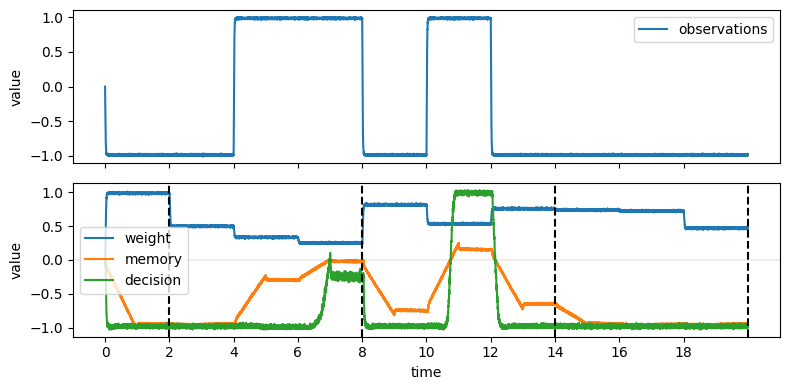

In [81]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
mem = sim.data[net.probe_memory].flatten()
decision = sim.data[net.probe_decision][:,0].flatten()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,4), sharex=True)
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=weight, ax=axes[1], label='weight')
sns.lineplot(x=times, y=mem, ax=axes[1], label='memory')
sns.lineplot(x=times, y=decision, ax=axes[1], label='decision')
axes[1].axhline(0, color='k', lw=0.1)
axes[1].axvline(env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+env.n_neighbors*env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+2*env.n_neighbors*env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+3*env.n_neighbors*env.time_sample, color='k', ls='--')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value', xticks=np.arange(0, env.T+env.dt, env.time_sample))
plt.tight_layout()

## Simulate all trials for one SID, record results

In [31]:
def run_sid(sid):
    empirical = pd.read_pickle(f"data/behavior.pkl").query("sid==@sid")
    trials = empirical['trial'].unique()
    
    columns = ['type', 'sid', 'trial', 'stage', 'action']
    dfs = []
    for trial in trials:
        print(f"sid {sid}, trial {trial}")
        env = Environment(sid=sid, trial=trial)
        net, sim = simulate(env=env, seed_net=sid, progress_bar=False)
        for stage in range(4):
            action_emp = empirical.query("trial==@trial and stage==@stage")['action'].to_numpy()[0]
            tidx = int((env.time_sample + stage*env.n_neighbors*env.time_sample)/env.dt)-2
            action_sim = sim.data[net.probe_decision][tidx][0]
            action_emp = 2*action_emp - 1  # converts [1,0] into [1,-1]
            action_sim = 1 if action_sim > 0 else -1  # turn real-value model decision (decoded from neural signal) into binary choice
            # print(f"stage {stage}, emp {action_emp}, sim {action_sim}")
            df = pd.DataFrame([['human', sid, trial, stage, action_emp]], columns=columns)
            dfs.append(df)
            df = pd.DataFrame([['model (WM)', sid, trial, stage, action_sim]], columns=columns)
            dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/wm_sid{sid}.pkl")
    return data

In [26]:
# sims = data.query("type=='model (WM)'")['action'].to_numpy()
# emps = data.query("type=='human'")['action'].to_numpy()
# print(np.where(sims==emps)[0])
# print(len(np.where(sims==emps)[0])/len(emps))

In [30]:
empirical = pd.read_pickle(f"data/behavior.pkl")
sids = empirical['sid'].unique()
for sid in sids:
    subdat = run_sid(sid)

sid 2, trial 1
sid 2, trial 2
sid 2, trial 3
sid 2, trial 4
sid 2, trial 5
sid 2, trial 6
sid 2, trial 7
sid 2, trial 8
sid 2, trial 9
sid 2, trial 10
sid 2, trial 11
sid 2, trial 12
sid 2, trial 13
sid 2, trial 14
sid 2, trial 15
sid 2, trial 16
sid 2, trial 17
sid 2, trial 18
sid 2, trial 19
sid 2, trial 20
sid 2, trial 21
sid 2, trial 22
sid 2, trial 23
sid 2, trial 24
sid 2, trial 25
sid 2, trial 26
sid 2, trial 27
sid 2, trial 28
sid 2, trial 29
sid 2, trial 30
sid 2, trial 31
sid 2, trial 32
sid 2, trial 33
sid 2, trial 34
sid 2, trial 35
sid 2, trial 36
sid 2, trial 37
sid 2, trial 38
sid 2, trial 39
sid 2, trial 40
sid 3, trial 1
sid 3, trial 2
sid 3, trial 3
sid 3, trial 4
sid 3, trial 5
sid 3, trial 6
sid 3, trial 7
sid 3, trial 8
sid 3, trial 9
sid 3, trial 10
sid 3, trial 11
sid 3, trial 12
sid 3, trial 13
sid 3, trial 14
sid 3, trial 15
sid 3, trial 16
sid 3, trial 17
sid 3, trial 18
sid 3, trial 19
sid 3, trial 20
sid 3, trial 21
sid 3, trial 22
sid 3, trial 23
sid 3, tri